# **Image Classification with the CIFAR-100 Dataset**

In this notebook, the [ConvNeXt V2 Large](https://huggingface.co/facebook/convnextv2-large-22k-384) model is fine-tuned using the [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for the image classification task. This dataset contains 60,000 RGB images, with 50,000 images designated for training and 10,000 for testing, distributed across 100 different classes, which are further grouped into 20 superclasses. In this case, a multi-class classification is performed considering all 100 categories, which increases the complexity of the task compared to classifying only the 20 superclasses or compared to the [CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/VisionTransformerModels/ImageClassification_ViT_CIFAR-10.ipynb) dataset, which has fewer classes.

The [ConvNeXt V2](https://huggingface.co/docs/transformers/model_doc/convnextv2) model is a pure convolutional neural network, pretrained using the FCMAE (Fully Convolutional Masked Autoencoder) framework. This framework is a convolutional-based approach for masked autoencoders (MAE), a mechanism typically using Transformer architectures. In MAE, a significant portion of the input (images) is masked during training, and the model learns to reconstruct the missing parts from the visible information, forcing the model to capture robust and generalizable features.

Additionally, ConvNeXt V2 introduces an extra layer called Global Response Normalization (GRN) to the original [ConvNeXt](https://huggingface.co/docs/transformers/model_doc/convnext) architecture. This layer helps improve the consistency and stability of the model's output by normalizing the response of neurons across the entire image, allowing for better generalization in complex computer vision tasks. The model has been fine-tuned with the [ImageNet-22K](https://www.image-net.org/) dataset at a resolution of 384x384 pixels, providing a solid foundation for high-precision classification tasks.


## **Imports**

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import AutoImageProcessor, TFAutoModelForImageClassification
from transformers import create_optimizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [8]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
epochs = 7
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
model_name = "facebook/convnextv2-large-22k-384"

## **Prepare the dataset for training**

### **Load the dataset**

In [7]:
(train_dataset, test_dataset), info = tfds.load("cifar100", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuf

In [9]:
num_classes = info.features["label"].num_classes
class_names = info.features['label'].names
num_superclasses = info.features["coarse_label"].num_classes
superclass_names = info.features["coarse_label"].names

# Normalize class names and superclass names
class_names = [" ".join(name.capitalize().split("_")) for name in class_names]
superclass_names = [" ".join(name.capitalize().split("_")) for name in superclass_names]

print("Number of classes:", num_classes)
print("Class names:", class_names, "\n")
print("Number of superclasses:", num_superclasses)
print("Superclass names:", superclass_names)

Number of classes: 100
Class names: ['Apple', 'Aquarium fish', 'Baby', 'Bear', 'Beaver', 'Bed', 'Bee', 'Beetle', 'Bicycle', 'Bottle', 'Bowl', 'Boy', 'Bridge', 'Bus', 'Butterfly', 'Camel', 'Can', 'Castle', 'Caterpillar', 'Cattle', 'Chair', 'Chimpanzee', 'Clock', 'Cloud', 'Cockroach', 'Couch', 'Crab', 'Crocodile', 'Cup', 'Dinosaur', 'Dolphin', 'Elephant', 'Flatfish', 'Forest', 'Fox', 'Girl', 'Hamster', 'House', 'Kangaroo', 'Keyboard', 'Lamp', 'Lawn mower', 'Leopard', 'Lion', 'Lizard', 'Lobster', 'Man', 'Maple tree', 'Motorcycle', 'Mountain', 'Mouse', 'Mushroom', 'Oak tree', 'Orange', 'Orchid', 'Otter', 'Palm tree', 'Pear', 'Pickup truck', 'Pine tree', 'Plain', 'Plate', 'Poppy', 'Porcupine', 'Possum', 'Rabbit', 'Raccoon', 'Ray', 'Road', 'Rocket', 'Rose', 'Sea', 'Seal', 'Shark', 'Shrew', 'Skunk', 'Skyscraper', 'Snail', 'Snake', 'Spider', 'Squirrel', 'Streetcar', 'Sunflower', 'Sweet pepper', 'Table', 'Tank', 'Telephone', 'Television', 'Tiger', 'Tractor', 'Train', 'Trout', 'Tulip', 'Turtle',

### **Preprocessing and data augmentation**

To combat overfitting, it is crucial to use data augmentation techniques, especially given that the training dataset is relatively small. Data augmentation will enhance the model's generalization capability for image classification. To achieve this, TensorFlow layers such as [``RandomFlip``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [``RandomTranslation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation), [``RandomRotation``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [``RandomZoom``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) will be used. These layers should only be applied to the training dataset during preprocessing, which is controlled by setting the parameter ``training=True``.

Regarding image preprocessing, the generic image processor class from Hugging Face, [AutoImageProcessor](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoImageProcessor), could be used, but it is not compatible with TensorFlow graphs, which would slow down training. Therefore, TensorFlow layers will be used for preprocessing, allowing the processing to be applied in parallel with training, significantly speeding up the training time. The [``Resizing``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) layer will be used to resize the images and make them compatible with the model, the [``Rescaling``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer to normalize the images in the range of ``[-1;1]``, and the [``Permute``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Permute) layer to rearrange the image channels into the second dimension, ensuring compatibility with the PyTorch model format. These three layers operate independently of the ``training`` parameter, so they are applied to both the training and testing datasets.

In [15]:
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  }
}

In [14]:
original_size = info.features["image"].shape
new_size = (image_processor.size["shortest_edge"], image_processor.size["shortest_edge"], 3)

original_size, new_size

((32, 32, 3), (384, 384, 3))

In [15]:
def function_data_augmentation(input_shape, output_shape):
  return tf.keras.Sequential([
      tf.keras.Input(shape=input_shape),
      tf.keras.layers.Resizing(output_shape[0], output_shape[1]),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
      tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
      tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
      tf.keras.layers.Rescaling(1/127.5, offset=-1),
      tf.keras.layers.Permute((3, 1, 2))
  ], name="data_augmentation")

In [16]:
tf.keras.backend.clear_session() #Clearing Keras memory

data_augmentation = function_data_augmentation(original_size, new_size)
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 384, 384, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 384, 384, 3)       0         
                                                                 
 random_translation (Random  (None, 384, 384, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 384, 384, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 384, 384, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 384, 384, 3) 

In [17]:
def prepare_dataset(dataset, training=True):
  if training:
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      batch(batch_size).
      map(lambda x, y : (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE).
      prefetch(AUTOTUNE)
  )

  return dataset

In [18]:
train_dataset = prepare_dataset(train_dataset)
test_dataset = prepare_dataset(test_dataset, training=False)

In [13]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(128, 3, 384, 384) (128,)


(-1.0, 1.0)

**Function to display and save images**

In [32]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  # Denormalize the images
  images = (tf.transpose(images, perm=[0, 2, 3, 1]) + 1) / 2

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=6.6,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  # Save images
  if save:
    plt.savefig(path)

  plt.tight_layout()
  plt.show()

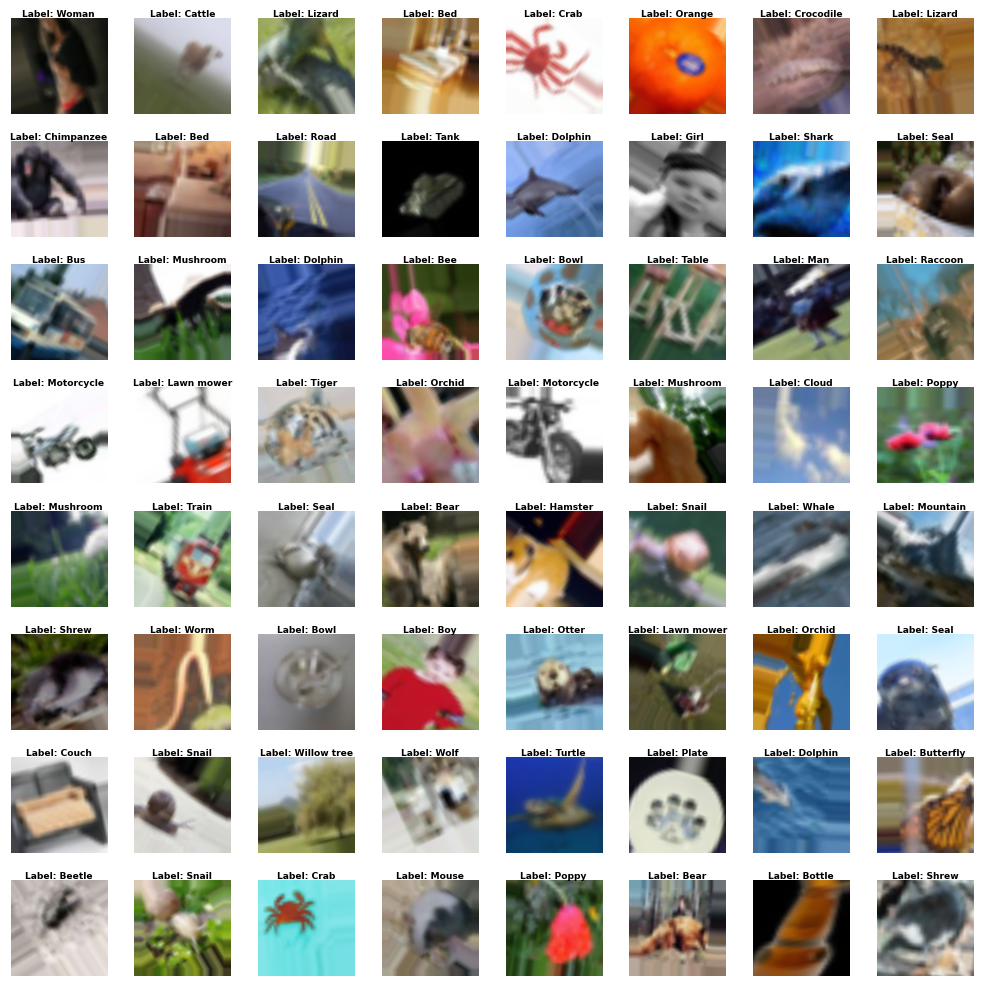

In [15]:
# Some images from the training dataset after data augmentation
show_images(images, labels, random=False, num_examples=64)

## **Model building and training**

To speed up the training time, Google's Colab TPU is used due to the large size of the model, which has about 200 million parameters. The model is loaded using the generic class [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which allows for the loading of a ViT model available on Hugging Face by specifying only its name.

In [9]:
# TPU setup

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForImageClassification.from_pretrained(
      model_name,
      num_labels=num_classes,
      ignore_mismatched_sizes=True
  )

  optimizer, lr_schedule = create_optimizer(
      init_lr=3e-5,
      num_train_steps=len(train_dataset)*epochs,
      weight_decay_rate=0.01,
      num_warmup_steps=0
  )
  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
      steps_per_execution=50
  )

model.summary()

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

Some weights of TFConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-large-22k-384 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (1536, 1000) in the checkpoint and (1536, 100) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (100,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_conv_next_v2_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnextv2 (TFConvNextV2Ma  multiple                  196419840 
 inLayer)                                                        
                                                                 
 classifier (Dense)          multiple                  153700    
                                                                 
Total params: 196573540 (749.87 MB)
Trainable params: 196573540 (749.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Callback to stop training early if validation accuracy does not improve for 1 epoch
patience = 1
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/7
391/391 [==============================] - 1026s 3s/step - loss: 1.0944 - accuracy: 0.7774 - val_loss: 0.3022 - val_accuracy: 0.9192
Epoch 2/7
391/391 [==============================] - 570s 1s/step - loss: 0.2645 - accuracy: 0.9271 - val_loss: 0.2459 - val_accuracy: 0.9308
Epoch 3/7
391/391 [==============================] - 571s 1s/step - loss: 0.1784 - accuracy: 0.9492 - val_loss: 0.2269 - val_accuracy: 0.9361
Epoch 4/7
391/391 [==============================] - 571s 1s/step - loss: 0.1238 - accuracy: 0.9640 - val_loss: 0.2231 - val_accuracy: 0.9397
Epoch 5/7
391/391 [==============================] - 572s 1s/step - loss: 0.0925 - accuracy: 0.9738 - val_loss: 0.2109 - val_accuracy: 0.9423
Epoch 6/7
391/391 [==============================] - 570s 1s/step - loss: 0.0685 - accuracy: 0.9807 - val_loss: 0.2113 - val_accuracy: 0.9441
Epoch 7/7
391/391 [==============================] - 571s 1s/step - loss: 0.0580 - accuracy: 0.9844 - val_loss: 0.2099 - val_accuracy: 0.9444


**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_ConvNeXTV2_CIFAR-100"
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.05284499004483223, 0.9859600067138672]
[0.20988444983959198, 0.9444000124931335]


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.4 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, metric="loss", renderer=None, with_patience=False):
  epochs = len(history["loss"])
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

  last_epoch = epochs-patience if with_patience else epochs
  fig.add_vline(
      x=last_epoch, line=dict(color="red", width=2, dash="dash"),
      annotation_text="End of Training", annotation_position="top left",
      annotation=dict(font_size=12, font_color="red")
  )

  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(metric="accuracy")
plot_metrics()

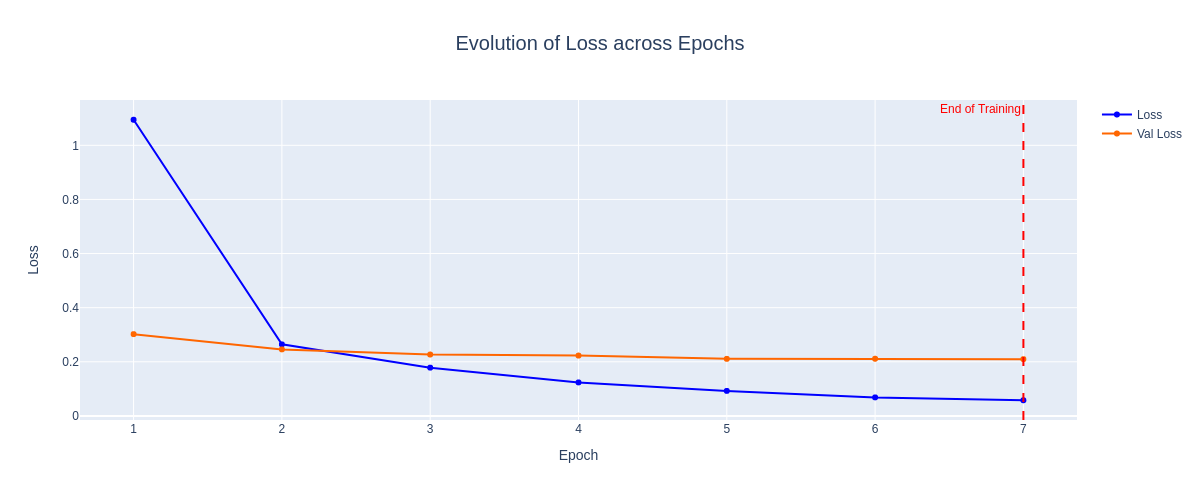

In [ ]:
# Static image for GitHub
plot_metrics(metric="accuracy", renderer="png")
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0).logits
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

Accuracy: 0.9444
F1 Score: 0.9445696026144245


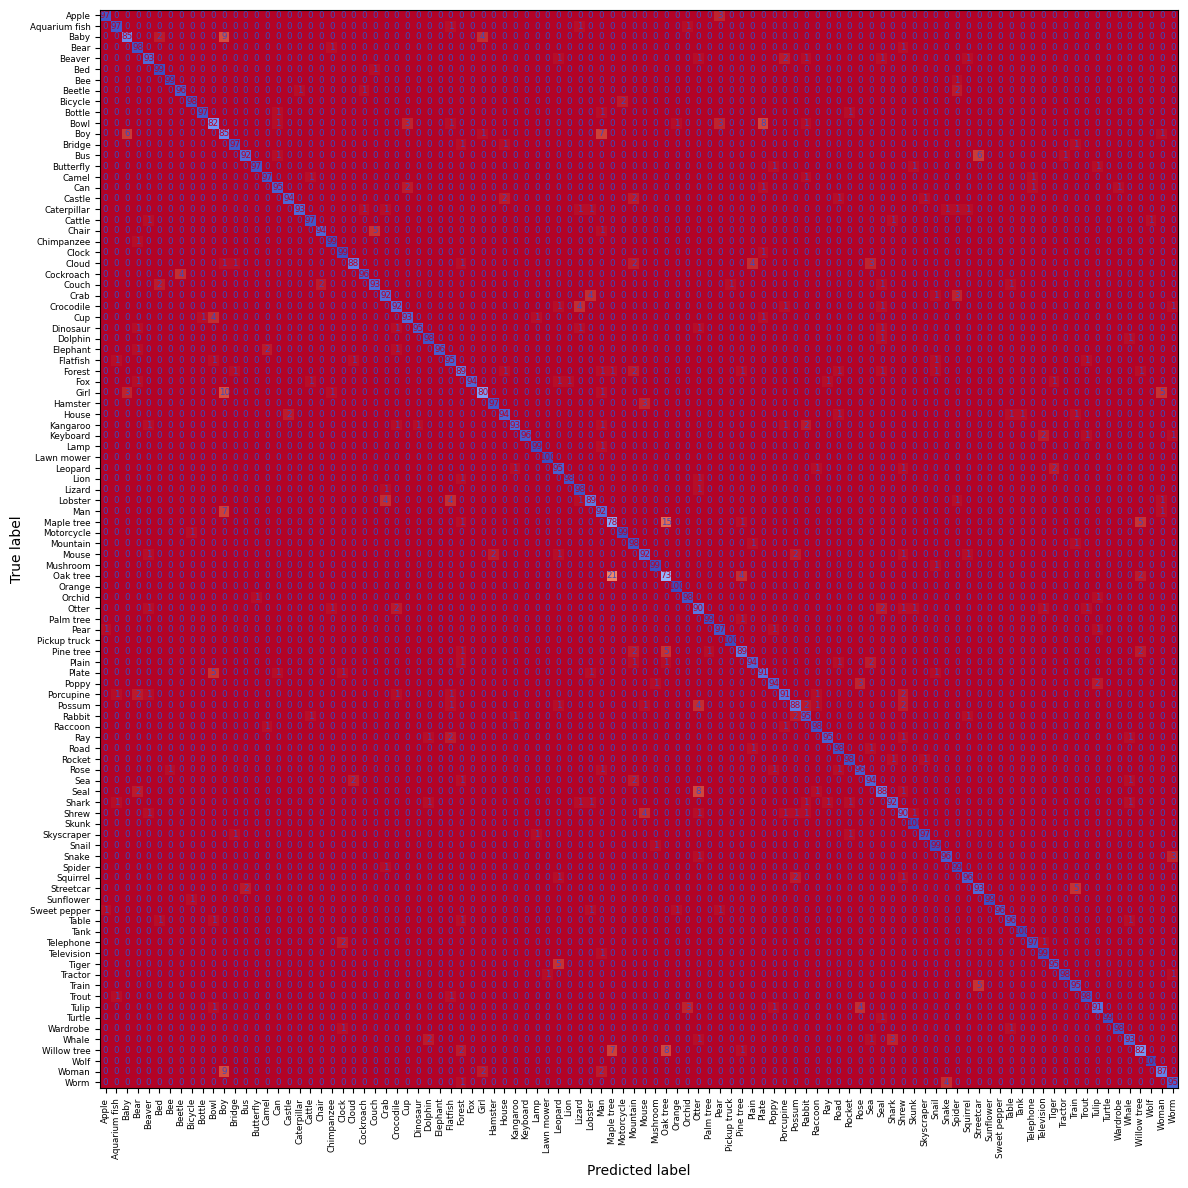

In [24]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(14, 14))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical")

for text in ax.texts:
  text.set_fontsize(6.3)

ax.tick_params(axis="x", labelsize=6.3)
ax.tick_params(axis="y", labelsize=6.3);

Since the dataset contains many classes, the confusion matrix may not be as clear as desired. Therefore, it is advisable to display the evaluation results in a Pandas DataFrame for a more detailed and clearer view.

In [25]:
# Extract the superclasses corresponding to each class
class_to_superclass = set()
for dic in tfds.load("cifar100", split="test"):
  class_to_superclass.add((dic["label"].numpy(), superclass_names[dic["coarse_label"].numpy()]))
  if len(class_to_superclass) == num_classes:
    break

class_to_superclass = sorted(class_to_superclass, key=lambda x: x[0])
class_to_superclass = [y for _, y  in class_to_superclass]

In [26]:
# Create the DataFrame with the most relevant variables for analysis
frequency = np.unique(labels_test, return_counts=True)[1]
correct_predictions = np.diag(cm)

df = pd.DataFrame({
    "Superclass": class_to_superclass,
    "Class": class_names,
    "Frequency": frequency,
    "Correct Predictions": correct_predictions,
    "Accuracy (%)": [round(per*100, 2) for per in correct_predictions/frequency]
})

# Sort the DataFrame in descending order according to accuracy
df = df.sort_values(by="Accuracy (%)", ascending=False)
#df

In [27]:
# View the first 50 classes
df.head(50)

Superclass          Class  Frequency  \
97                Large carnivores           Wolf        100   
85                      Vehicles 2           Tank        100   
75                  Medium mammals          Skunk        100   
53            Fruit and vegetables         Orange        100   
58                      Vehicles 1   Pickup truck        100   
41                      Vehicles 2     Lawn mower        100   
87    Household electrical devices     Television        100   
77        Non-insect invertebrates          Snail        100   
51            Fruit and vegetables       Mushroom        100   
79        Non-insect invertebrates         Spider        100   
22    Household electrical devices          Clock        100   
21  Large omnivores and herbivores     Chimpanzee        100   
40    Household electrical devices           Lamp        100   
48                      Vehicles 1     Motorcycle        100   
56                           Trees      Palm tree        100   
82                         Flowers      Sunflower        100   
5              Household furniture            Bed        100   
6                          Insects            Bee        100   
93                        Reptiles         Turtle        100   
66                  Medium mammals        Raccoon        100   
49    Large natural outdoor scenes       Mountain        100   
68   Large man-made outdoor things           Road        100   
69                      Vehicles 2         Rocket        100   
30                 Aquatic mammals        Dolphin        100   
43                Large carnivores           Lion        100   
44                        Reptiles         Lizard        100   
54                         Flowers         Orchid        100   
89                      Vehicles 2        Tractor        100   
94             Household furniture       Wardrobe        100   
91                            Fish          Trout        100   
3                 Large carnivores           Bear        100   
8                       Vehicles 1        Bicycle        100   
1                             Fish  Aquarium fish        100   
9                  Food containers         Bottle        100   
36                   Small mammals        Hamster        100   
14                         Insects      Butterfly        100   
12   Large man-made outdoor things         Bridge        100   
19  Large omnivores and herbivores         Cattle        100   
57            Fruit and vegetables           Pear        100   
86    Household electrical devices      Telephone        100   
0             Fruit and vegetables          Apple        100   
15  Large omnivores and herbivores          Camel        100   
76   Large man-made outdoor things     Skyscraper        100   
70                         Flowers           Rose        100   
80                   Small mammals       Squirrel        100   
7                          Insects         Beetle        100   
83            Fruit and vegetables   Sweet pepper        100   
84             Household furniture          Table        100   
24                         Insects      Cockroach        100   
39    Household electrical devices       Keyboard        100   

    Correct Predictions  Accuracy (%)  
97                  100         100.0  
85                  100         100.0  
75                  100         100.0  
53                  100         100.0  
58                  100         100.0  
41                  100         100.0  
87                   99          99.0  
77                   99          99.0  
51                   99          99.0  
79                   99          99.0  
22                   99          99.0  
21                   99          99.0  
40                   99          99.0  
48                   99          99.0  
56                   99          99.0  
82                   99          99.0  
5                    99          99.0  
6                    99          99.0  

In [28]:
# View the last 50 classes
df.tail(50)

Superclass        Class  Frequency  \
78                        Reptiles        Snake        100   
31  Large omnivores and herbivores     Elephant        100   
99        Non-insect invertebrates         Worm        100   
67                            Fish          Ray        100   
65                   Small mammals       Rabbit        100   
42                Large carnivores      Leopard        100   
32                            Fish     Flatfish        100   
29                        Reptiles     Dinosaur        100   
16                 Food containers          Can        100   
88                Large carnivores        Tiger        100   
90                      Vehicles 1        Train        100   
34                  Medium mammals          Fox        100   
71    Large natural outdoor scenes          Sea        100   
37   Large man-made outdoor things        House        100   
17   Large man-made outdoor things       Castle        100   
20             Household furniture        Chair        100   
60    Large natural outdoor scenes        Plain        100   
62                         Flowers        Poppy        100   
38  Large omnivores and herbivores     Kangaroo        100   
28                 Food containers          Cup        100   
25             Household furniture        Couch        100   
81                      Vehicles 2    Streetcar        100   
4                  Aquatic mammals       Beaver        100   
95                 Aquatic mammals        Whale        100   
18                         Insects  Caterpillar        100   
13                      Vehicles 1          Bus        100   
27                        Reptiles    Crocodile        100   
46                          People          Man        100   
50                   Small mammals        Mouse        100   
73                            Fish        Shark        100   
26        Non-insect invertebrates         Crab        100   
63                  Medium mammals    Porcupine        100   
92                         Flowers        Tulip        100   
61                 Food containers        Plate        100   
74                   Small mammals        Shrew        100   
55                 Aquatic mammals        Otter        100   
59                           Trees    Pine tree        100   
33    Large natural outdoor scenes       Forest        100   
45        Non-insect invertebrates      Lobster        100   
72                 Aquatic mammals         Seal        100   
64                  Medium mammals       Possum        100   
23    Large natural outdoor scenes        Cloud        100   
98                          People        Woman        100   
2                           People         Baby        100   
11                          People          Boy        100   
96                           Trees  Willow tree        100   
10                 Food containers         Bowl        100   
35                          People         Girl        100   
47                           Trees   Maple tree        100   
52                           Trees     Oak tree        100   

    Correct Predictions  Accuracy (%)  
78                   96          96.0  
31                   96          96.0  
99                   95          95.0  
67                   95          95.0  
65                   95          95.0  
42                   95          95.0  
32                   95          95.0  
29                   95          95.0  
16                   95          95.0  
88                   95          95.0  
90                   95          95.0  
34                   94          94.0  
71                   94          94.0  
37                   94          94.0  
17                   94          94.0  
20                   94          94.0  
60                   94          94.0  
62                   94          94.0  
38                   93          93.0  
28                   93          93.0  
25                   

In [29]:
df["Accuracy (%)"].mean()

94.44

It is observed that the test dataset is balanced, with 1,000 images per class. Additionally, several classes show that the model achieved an accuracy of 99% or higher, such as ``Wolf`` and ``Turtle``. However, there are also classes where the model struggles to classify them correctly, with the lowest accuracy being 73% for the ``Oak tree`` class.

## **Predictions with the trained model**

### **Test dataset**

In [30]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

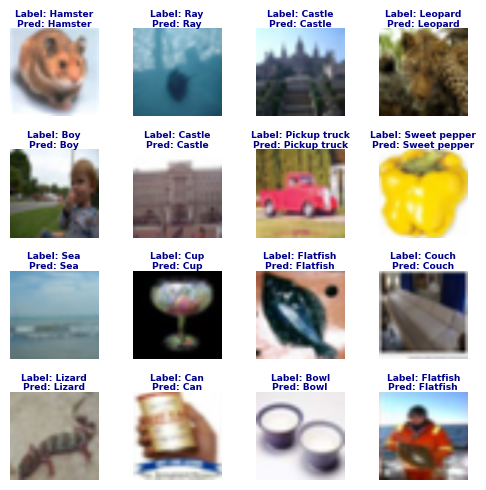

In [33]:
show_images(images_test, labels_test, labels_test_pred, num_examples=16)

In [44]:
show_images(
    images_test, labels_test, labels_test_pred, save=True,
    num_examples=49, path="ImageClassification_ConvNeXTV2_CIFAR-100.png"
)

In [35]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

In [37]:
show_images(images_test, labels_test, labels_test_pred, num_examples=81)

### **Other images**

In [11]:
# Load the trained model
tf.keras.backend.clear_session()
model = TFAutoModelForImageClassification.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFConvNextV2ForImageClassification.

All the layers of TFConvNextV2ForImageClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/ImageClassification_ConvNeXTV2_CIFAR-100.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFConvNextV2ForImageClassification for predictions without further training.


In [12]:
# Function to predict images from the internet
def predict_image(url, label=None):
  path = tf.keras.utils.get_file(origin=url)
  image = tf.keras.utils.load_img(path)
  inputs = image_processor(image, return_tensors="tf")

  pred = model(**inputs).logits
  pred = np.argmax(pred, axis=-1)
  pred = class_names[pred[0]]

  if label is not None:
    color = "#00008B" if label == pred else "red"
    plt.title(f"Label: {label}\nPred: {pred}", color=color)
  else:
    plt.title(f"Pred: {pred}")

  plt.imshow(image)
  plt.axis("off")
  plt.tight_layout();

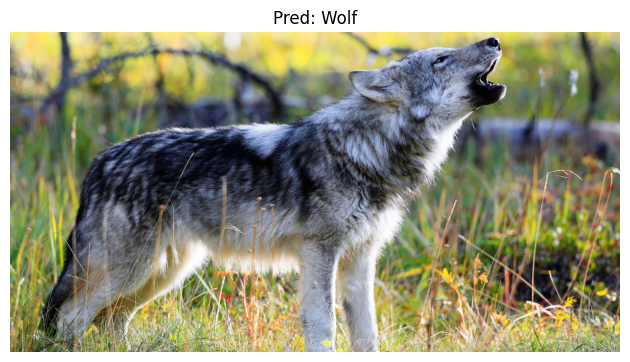

In [17]:
url = "https://d1jyxxz9imt9yb.cloudfront.net/article/7386/meta_image/regular/JohnEMarriott_2009-10_BanffNationalPark-Alberta-Canada_WolfHowling_wlf0054_reduced.jpg"
#label = "Wolf"

predict_image(url)

In [18]:
url = "https://images.immediate.co.uk/production/volatile/sites/10/2018/02/3aa7e6ab-3dea-4440-8825-78ce8556fc6a-45fbc11.jpg"
label = "Sunflower"

predict_image(url, label)

352889/352889 [==============================] - 0s 0us/step


46567/46567 [==============================] - 0s 0us/step


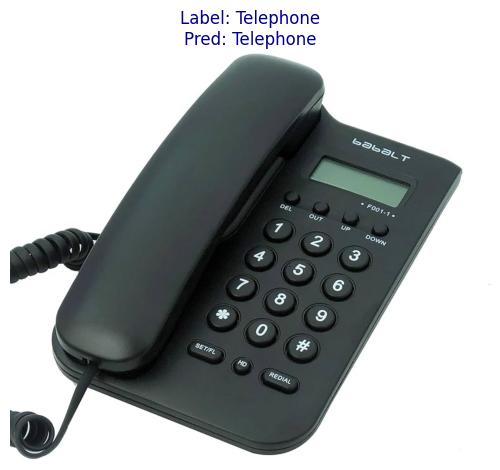

In [19]:
url = "https://m.media-amazon.com/images/I/61k-0lI49JL._AC_UF1000,1000_QL80_.jpg"
label = "Telephone"

predict_image(url, label)

173882/173882 [==============================] - 0s 0us/step


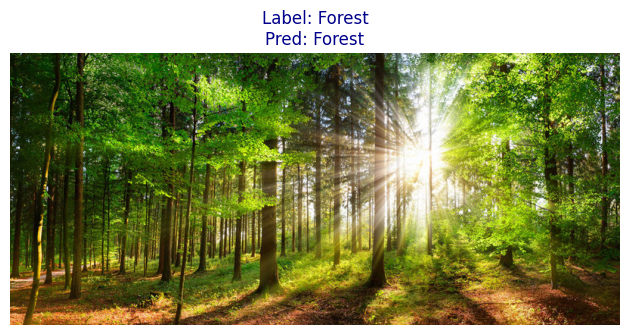

In [20]:
url = "https://t4.ftcdn.net/jpg/02/55/17/43/360_F_255174366_ojDuATz84e5h7lIlxh2moUJa9Kpd5wKk.jpg"
label = "Forest"

predict_image(url, label)

131555/131555 [==============================] - 0s 0us/step


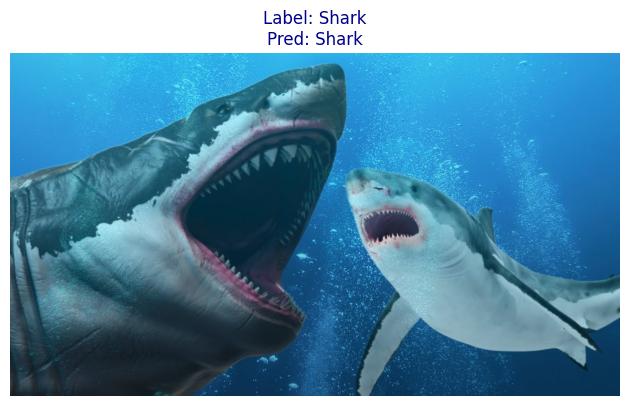

In [21]:
url = "https://i.ytimg.com/vi/VmjhqB2rGjI/maxresdefault.jpg"
label = "Shark"

predict_image(url, label)

143775/143775 [==============================] - 0s 0us/step


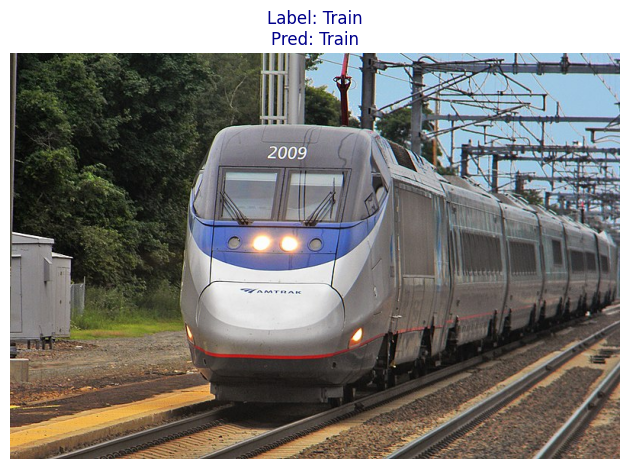

In [22]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Acela_old_saybrook_ct_summer2011.jpg/800px-Acela_old_saybrook_ct_summer2011.jpg"
label = "Train"

predict_image(url, label)

521029/521029 [==============================] - 0s 0us/step


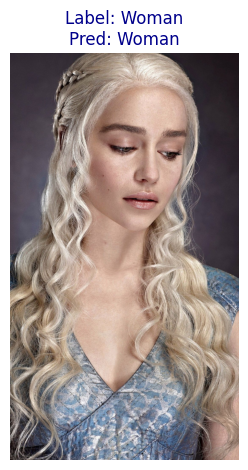

In [23]:
url = "https://i.pinimg.com/originals/7f/26/70/7f267045def2aceb68be1191da6c62b3.jpg"
label = "Woman"

predict_image(url, label)

**Conclusion:** The model achieved **98.6%** accuracy on the training dataset and **94.44%** accuracy along with an F1 score of **94.46%** on the test dataset. These results indicate that the model is highly effective at classifying images in the CIFAR-100 dataset, maintaining a good balance between precision and recall, despite the challenge posed by the large number of classes and the limited number of images available for fine-tuning the ConvNeXt V2 Large model.

A slight overfitting was observed despite the use of data augmentation techniques, which can be attributed to the relatively small size of the training dataset, consisting of only 50,000 images spread across 100 classes. However, considering the performance of the best models currently available, the results on the test dataset are excellent. If the training had continued for more epochs, it is likely that the accuracy on the training dataset would have reached 100%, while the accuracy on the test dataset might have started to decrease or stabilize.

With a **94.44%** accuracy on the test dataset, the fine-tuned model would currently rank among the top four positions (the top model achieves **96.08%** accuracy) according to [Papers With Code](https://paperswithcode.com/sota/image-classification-on-cifar-100), highlighting the robustness of the ConvNeXt V2 model and the effectiveness of the fine-tuning performed in this notebook.